## Лабораторная работа 5
### Машины опорных векторов и ядра скалярного произведения
В данной лабораторной работе рассматривается использование машин опорных векторов для решения задач классификации и регрессии.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

plt.rcParams["figure.figsize"] = (20,10)

(2399, 2) (2399,)
(600, 2) (600,)


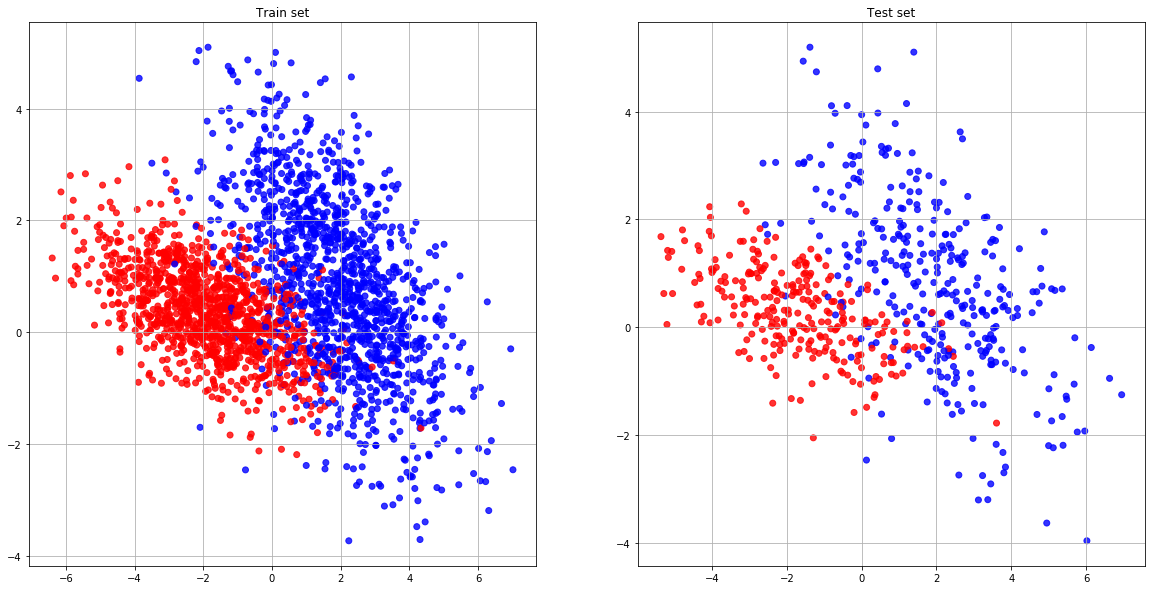

In [3]:
df = pd.read_csv('../lab2/2_features/9.csv')
X = df.iloc[:, 0:2].to_numpy()
y = df.iloc[:, 2].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

color_map = {0: 'red', 1: 'blue'}

_, (axs0, axs1) = plt.subplots(1, 2)
axs0.scatter(X_train[:, 0], X_train[:, 1], c=np.vectorize(color_map.get)(y_train), alpha=0.8);
axs0.set_title('Train set')
axs0.grid()

axs1.scatter(X_test[:, 0], X_test[:, 1], c=np.vectorize(color_map.get)(y_test), alpha=0.8);
axs1.set_title('Test set')
axs1.grid()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

## Классификация с использование SVM
Будем использовать линейное, полиномиальное степеней 2-5 и радиальное RBF ядро.

In [4]:
from sklearn import svm

def get_margin_width(clf):
    X_sup = clf.support_vectors_
    sup_coef = clf.dual_coef_
    W = np.dot(X_sup.T, sup_coef.T)
    return 2 / np.sqrt(np.sum(W ** 2))

def plot_SVC(params, ax):
    clf = svm.SVC(**params)
    clf.fit(X_train, y_train)
    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    SV_num = clf.support_.shape[0]
    
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    h = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    xy = np.c_[xx.ravel(), yy.ravel()]    
    Z = clf.predict(xy).reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=5)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    kernel = params['kernel']
    if kernel == 'poly':
        kernel += f" with degree {params['degree']}"

    ax.set_title(kernel)
    print('Kernel:', kernel)    
    print(f'Accuracy: Train {train_acc:.4f}, Test {test_acc:.4f}')
    print('Number of support vectors:', SV_num)
    print(f'Margin width {get_margin_width(clf):.3f}')
    print()
    
    return clf

Kernel: linear
Accuracy: Train 0.9287, Test 0.9217
Number of support vectors: 437
Margin width 1.199

Kernel: rbf
Accuracy: Train 0.9391, Test 0.9367
Number of support vectors: 462
Margin width 0.025

Kernel: poly with degree 2
Accuracy: Train 0.9391, Test 0.9400
Number of support vectors: 376
Margin width 2.740

Kernel: poly with degree 4
Accuracy: Train 0.9379, Test 0.9417
Number of support vectors: 378
Margin width 4.002



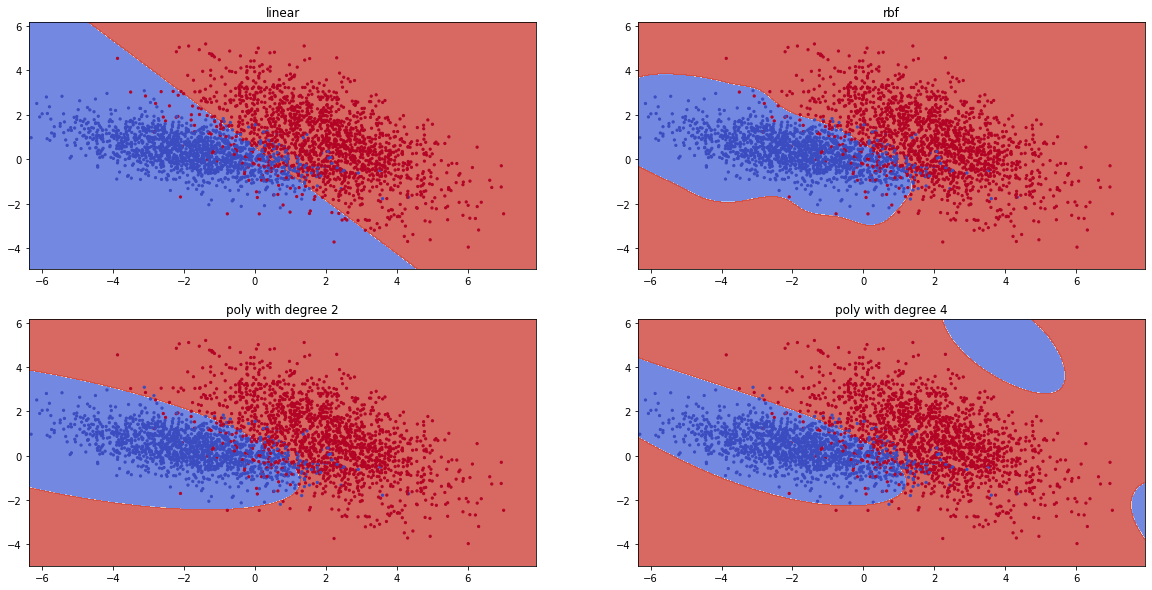

In [96]:
_, ax = plt.subplots(2, 2)

params_lin = dict(kernel='linear', C=1, random_state=1)
plot_SVC(params_lin, ax[0, 0])

params_rbf = dict(kernel='rbf', gamma=1.0, C=1, random_state=1)
plot_SVC(params_rbf, ax[0, 1])

params_poly_2 = dict(kernel='poly', degree=2, coef0=1.0, gamma=1.0, C=1, random_state=1)
plot_SVC(params_poly_2, ax[1, 0])

params_poly_4 = dict(kernel='poly', degree=4, coef0=1.0, gamma=1.0, C=1, random_state=1)
plot_SVC(params_poly_4, ax[1, 1]);

Как видно, лучшую точность показало полиномиальное ядро 4 степени.
Но по точности и по количеству опорных векторов полиномиальное степени 2 отстает несильно.
Это видно и на графике с разделением плоскости.

Линейное ядро хуже на 2% по точности.
И сложнее, т.к. использует на 100 опорных векторов больше.


Радиальное `RBF` ядро на тренировочной выборке показывает такую же точность, что и полиномиальные ядра, но на тренировочной выборке хуже на 0.3%.
Также оно имеет более высокую сложность, т.к. использует на 100 опорных векторов больше, чем полиномиальные.

В данном случае оказывается, что более точные модели используют меньше опорных векторов.

### Оптимальные $C$ и $\varepsilon$
Будем находить сначала оптимальное $C$, параметр, отвечающий за регуляризацию, чтобы точность на тестовых данных была наименьшей.
Затем таким же способом подберем $\varepsilon$, взяв $C$ оптимальное.

In [5]:
def _plot_rbf(ax, t, metrics, best_ind, x_label, title):
    ax.plot(t, metrics)
    ax.scatter(t[best_ind], metrics[best_ind], marker='o', color='red')
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(title)
    ax.set_title(title)
    ax.grid()

def change_rbf(C_params, sigma_params):
    n_SV = []
    margins = []
    acc_train = []
    acc_test = []
    for C in C_params:
        for sigma in sigma_params:
            gamma = 1 / (sigma ** 2)
            d = {'C': C, 'gamma': gamma}
            clf = svm.SVC(kernel='rbf', random_state=1, **d).fit(X_train, y_train)
            
            n_SV.append(clf.support_.size)
            margins.append(get_margin_width(clf))
            acc_train.append(clf.score(X_train, y_train))
            acc_test.append(clf.score(X_test, y_test))

    _, ax = plt.subplots(2, 2)
    
    x_label = 'C' if len(C_params) > 1 else r'$\sigma$'
    t = C_params if len(C_params) > 1 else sigma_params
    best_ind = np.argmax(acc_test)
    
    _plot_rbf(ax[0, 0], t, n_SV, best_ind, x_label, 'Number of support vector')
    _plot_rbf(ax[0, 1], t, margins, best_ind, x_label, 'Margin width')
    
    _plot_rbf(ax[1, 0], t, acc_train, best_ind, x_label, 'Train accuracy')
    _plot_rbf(ax[1, 1], t, acc_test, best_ind, x_label, 'Test accuracy')
    
    return best_ind

Best C: 0.1003030303030303


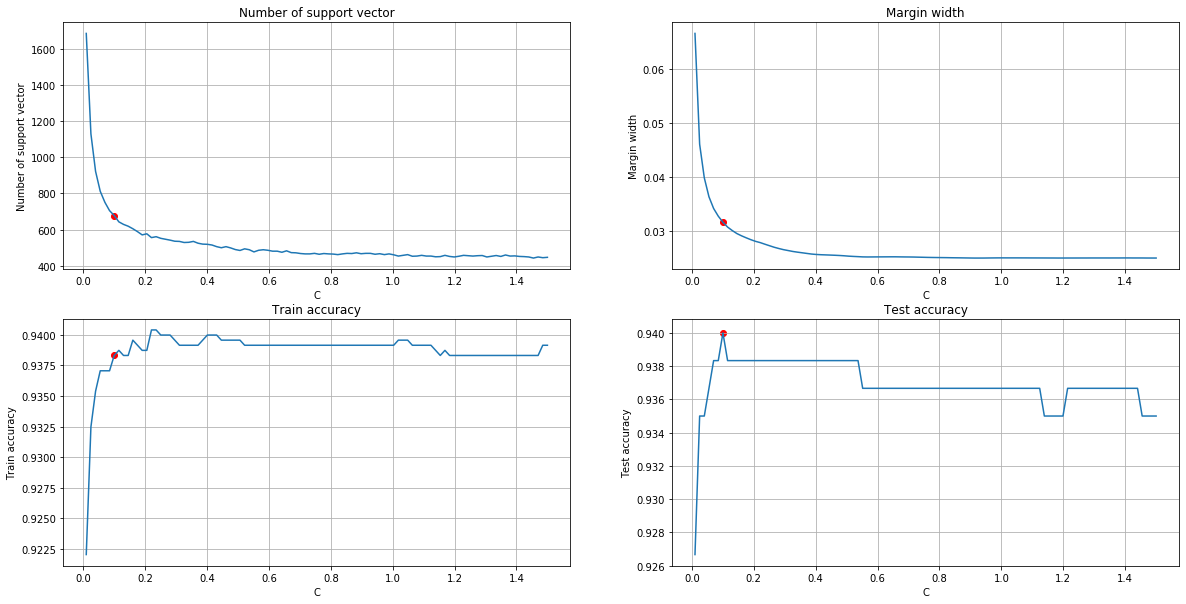

In [6]:
C_params = np.linspace(1e-2, 1.5, 100)
ind = change_rbf(C_params, [1.0])
best_C = C_params[ind]
print('Best C:', best_C)

Best sigma: 0.5668686868686869


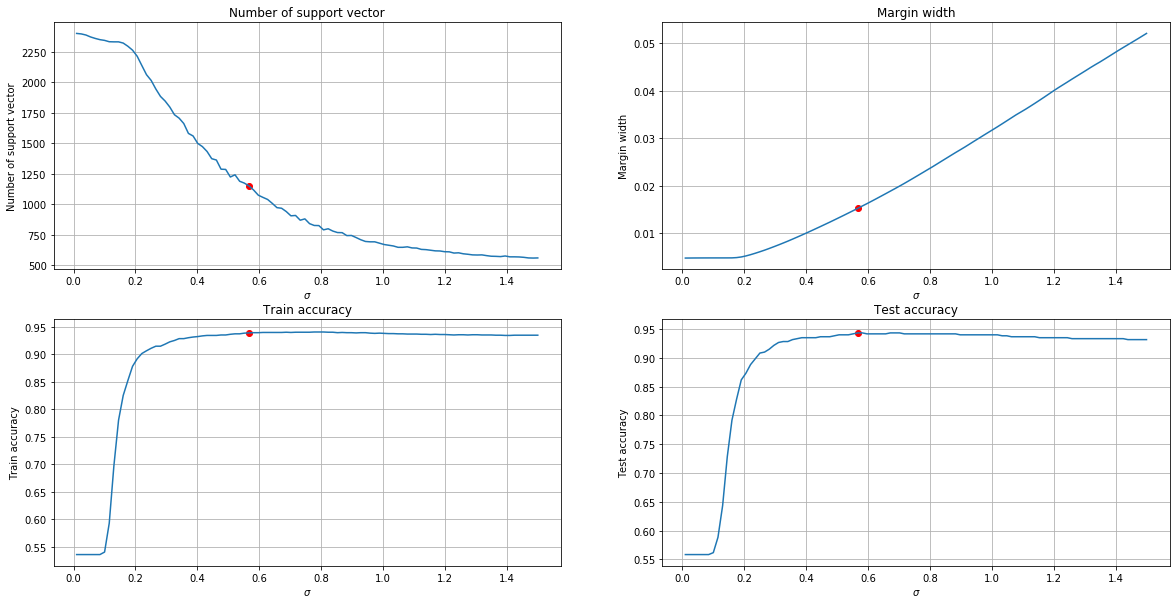

In [22]:
sigma_params = np.linspace(1e-2, 1.5, 100)
ind = change_rbf([best_C], sigma_params)
best_sigma = sigma_params[ind]
print('Best sigma:', best_sigma)

Kernel: rbf
Accuracy: Train 0.9391, Test 0.9367
Number of support vectors: 462
Margin width 0.025

Kernel: rbf
Accuracy: Train 0.9391, Test 0.9433
Number of support vectors: 1150
Margin width 0.015



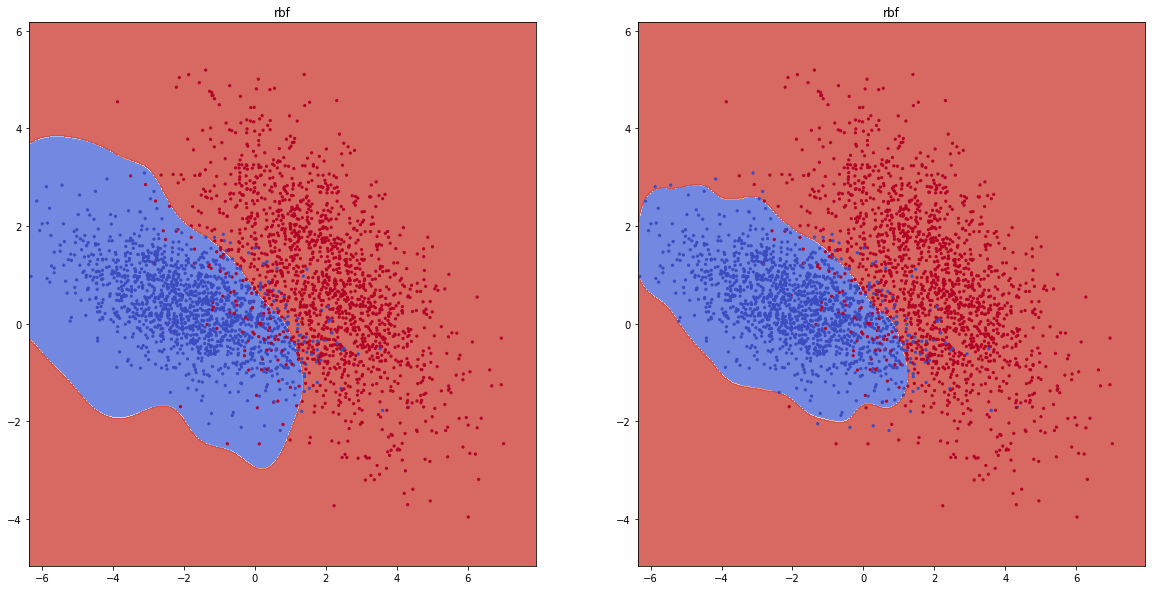

In [30]:
best_gamma = 1 / (best_sigma ** 2)
_, ax = plt.subplots(1, 2)

params_rbf = dict(kernel='rbf', gamma=1.0, C=1.0, random_state=1)
plot_SVC(params_rbf, ax[0])

best_rbf = dict(kernel='rbf', gamma=best_gamma, C=best_C, random_state=1)
plot_SVC(best_rbf, ax[1]);

Видно, что выбрав оптимальные параметры, мы смогли увеличить точность на тестовых данных на 1%.
Точность на тренировочных данных осталась прежней, т.к. мы пытались максимизировать только точность для тестовых данных.

Ширина зазора уменьшилась почти в 2 раза, но при этом повысилась сложность модели, т.е. увеличилось количество опорных векторов чуть больше, чем в 2 раза.

По графикам разбиения видно, что область разделения для одного из классов уменьшилась, возможно, в 2 раза.

## Регрессия с использование SVM
Будем использовать линейное, полиномиальное степеней 2-10 и радиальное RBF ядро.

(79, 1) (79,)
(20, 1) (20,)


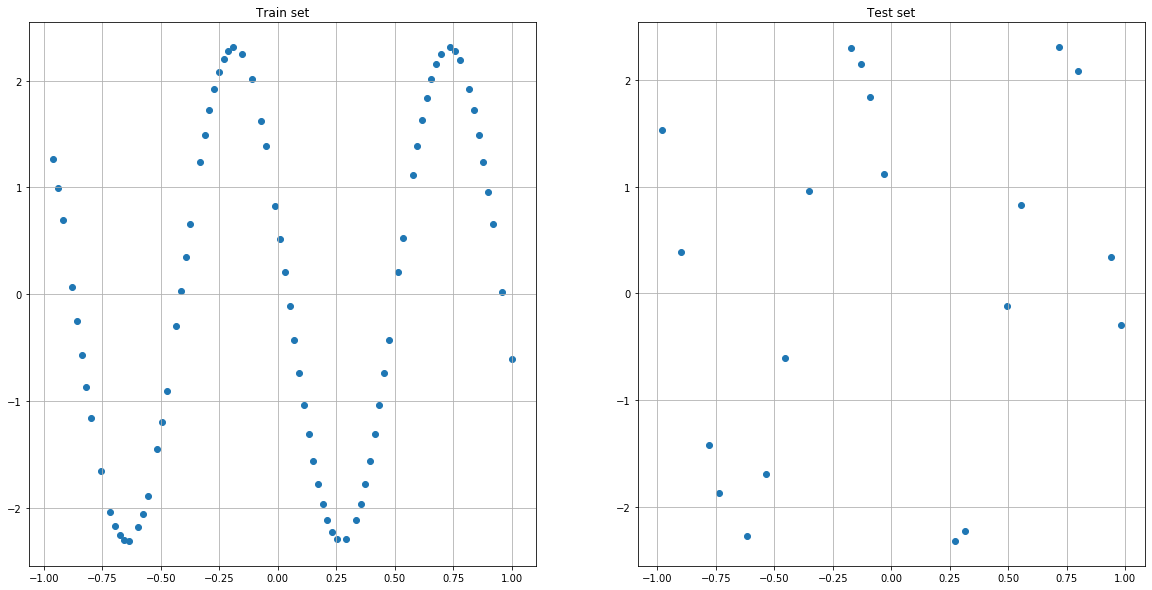

In [8]:
df = pd.read_csv('./nonlinear/9.csv')
X = df.iloc[:, 0].to_numpy().reshape((-1, 1))
y = df.iloc[:, 1].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


_, (axs0, axs1) = plt.subplots(1, 2)
axs0.scatter(X_train, y_train)
axs0.set_title('Train set')
axs0.grid()

axs1.scatter(X_test, y_test)
axs1.set_title('Test set')
axs1.grid()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

С помощью кросс-валидации подберем примерные параметры $\gamma$, $C$, $\varepsilon$ для `RBF` ядра.

In [25]:
from sklearn.model_selection import GridSearchCV

def get_best_model(estimator, param_grid):

    grid_model = GridSearchCV(estimator, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_model.fit(X_train, y_train)
    best_model = grid_model.best_estimator_

    print(f'Best params: {grid_model.best_params_}')
    print(f'Train accuracy: {mean_squared_error(y_train, best_model.predict(X_train))}')
    print(f'Test accuracy: {mean_squared_error(y_test, best_model.predict(X_test))}')
    
    return best_model

In [26]:
params = {
    'gamma': np.linspace(1, 5, 5),
    'C': np.linspace(0.1, 100, 10),
    'epsilon': np.linspace(1e-5, 1, 5)
}

model = get_best_model(svm.SVR(kernel='rbf'), params)

Best params: {'C': 88.9, 'epsilon': 1e-05, 'gamma': 5.0}
Train accuracy: 4.922111560405152e-07
Test accuracy: 5.6087746447327855e-06


/home/asdor45/education/ML/env_lab/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Видно, что с помощью кросс-валидации мы смогли почти полностью апроксимировать синусоиду.

In [65]:
params = {
    'gamma': np.linspace(1, 5, 10),
#     'C': np.linspace(0.1, 100, 10),
#     'epsilon': np.linspace(1e-5, 1, 5)
}

model = get_best_model(svm.SVR(kernel='poly', degree=8, coef0=1, C=100, epsilon=.1), params)

Best params: {'gamma': 1.0}
Train accuracy: 0.023529101376069273
Test accuracy: 0.06464466374533033


/home/asdor45/education/ML/env_lab/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Kernel: linear
MSE: Train 2.2912, Test 2.5593
Number of support vectors: 77

Kernel: rbf
MSE: Train 0.0000, Test 0.0000
Number of support vectors: 79

Kernel: poly with degree 2
MSE: Train 2.2662, Test 2.7324
Number of support vectors: 78

Kernel: poly with degree 10
MSE: Train 0.0066, Test 0.0114
Number of support vectors: 31



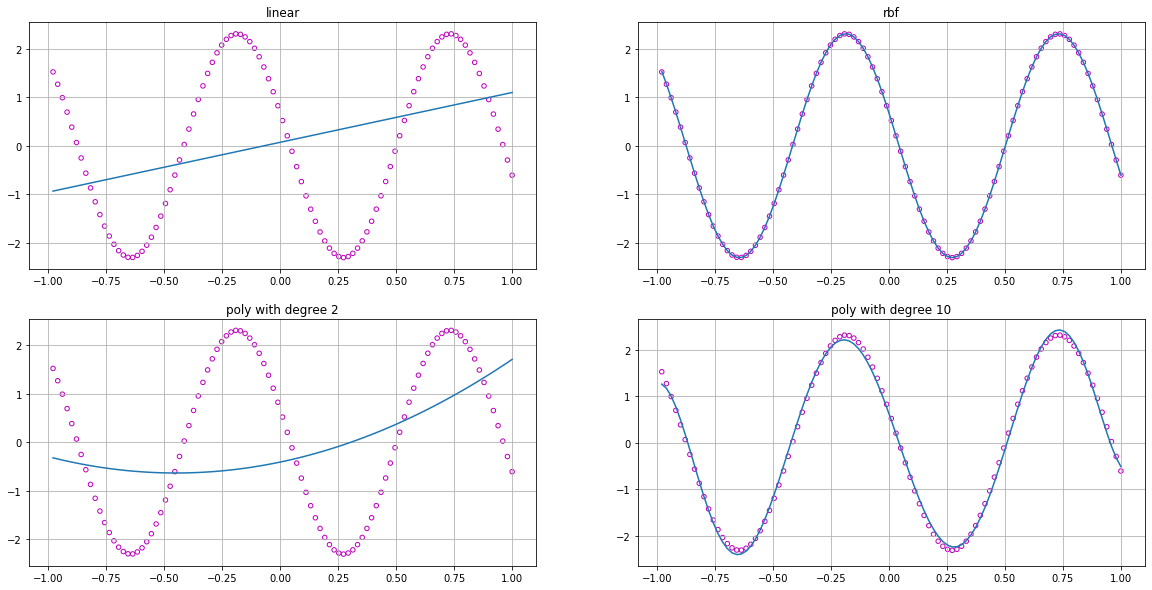

In [83]:
from sklearn import svm
from sklearn.metrics import mean_squared_error

def plot_SVR(params, ax):
    svr = svm.SVR(**params)
    svr.fit(X_train, y_train)
    train_mse = mean_squared_error(y_train, svr.predict(X_train))
    test_mse = mean_squared_error(y_test, svr.predict(X_test))
    
    x_min, x_max = X.min() - 1, X.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1

    ax.scatter(X, y, s=20, facecolor="none", edgecolor='m')
    ax.plot(X, svr.predict(X))
    ax.grid()
    
    kernel = params['kernel']
    if kernel == 'poly':
        kernel += f" with degree {params['degree']}"

    ax.set_title(kernel)
    print('Kernel:', kernel)    
    print(f'MSE: Train {train_mse:.4f}, Test {test_mse:.4f}')
    print('Number of support vectors:', svr.support_.size)
    print()
    
    return svr

_, ax = plt.subplots(2, 2)

params_lin = dict(kernel='linear', C=1, epsilon=.1)
plot_SVR(params_lin, ax[0, 0])

params_rbf = dict(kernel='rbf', gamma=5.0, C=100, epsilon=1e-5)
plot_SVR(params_rbf, ax[0, 1])

params_poly_2 = dict(kernel='poly', degree=2, coef0=1.0, gamma=1.0, C=100, epsilon=.1)
plot_SVR(params_poly_2, ax[1, 0])

params_poly_4 = dict(kernel='poly', degree=10, coef0=1.0, gamma=1.0, C=100, epsilon=.1)
plot_SVR(params_poly_4, ax[1, 1]);

Как и показывалось ранее, использование `RBF` ядра с оптимальными параметрами позволяет очень хорошо апроксимировать данные данные.
Хотя, здесь явное переобучение, т.к. модель использует 79 опорных векторов.
Но т.к. дана синусоида без шумов, плохих эффектов здесь не наблюдается.

Линейное и полиномальное ядро 2й степени ожидаемо (из-за вида данных) показывают плохую точность.

Полиномальное ядро 10й степени показывает неплохую точность, и отличается более простой моделью, использует 31 опорный вектор.
Попробуем улучшить эту модель, численно подобрав оптимальные параметры $C$, $\varepsilon$.


In [84]:
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint

def fun(x):
    C = x[0]
    eps = x[1]
    if C < 1e-5:
        return np.inf # С помощью метода Нелдера-Мида лучше минимизируется, пришлось так задавать ограничения
    if eps < 1e-5:
        return np.inf
    svr = svm.SVR(kernel='poly', degree=10, coef0=1.0, gamma=1.0, C=C, epsilon=eps)
    svr.fit(X_test, y_test)
    mse = mean_squared_error(y_test, svr.predict(X_test))
    
    return mse

x0 = [100, .1]

res = minimize(fun, x0, method='Nelder-Mead', options={'maxiter': 30, 'disp': True})
best_C, best_eps = res.x
print(f'Optimal params: C: {best_C}, eps: {best_eps}')

Optimal params: C: 869.957275390625, eps: 0.008543701171872656


Kernel: poly with degree 10
MSE: Train 0.0006, Test 0.0049
Number of support vectors: 62



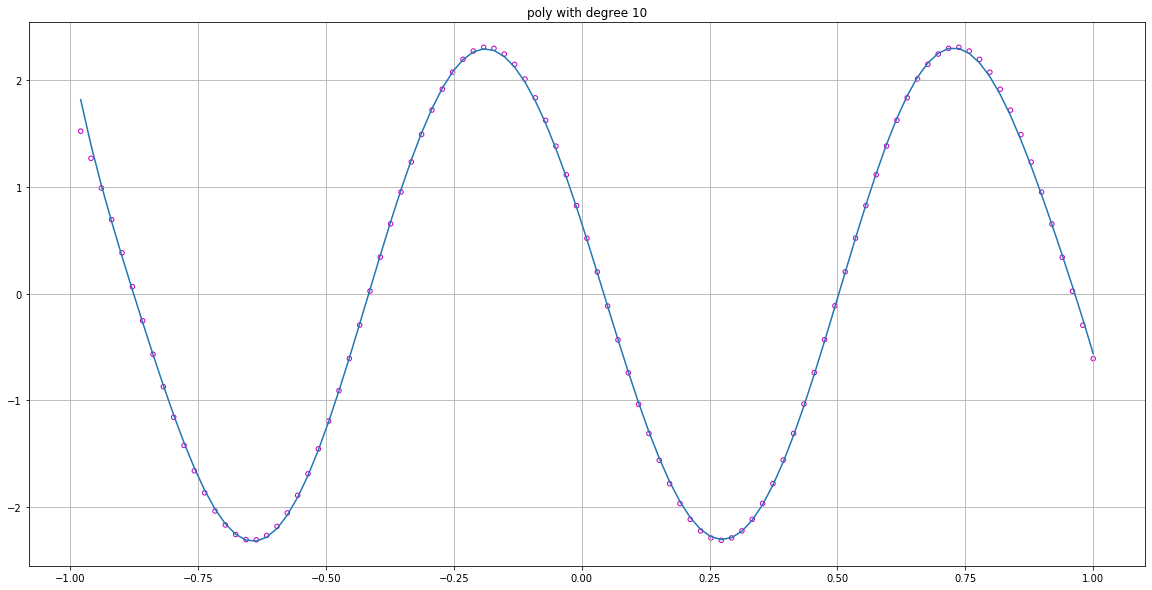

In [82]:
_, ax = plt.subplots(1, 1)
params_rbf = dict(kernel='poly', degree=10, coef0=1.0, gamma=1.0, C=best_C, epsilon=best_eps)
plot_SVR(params_rbf, ax);

Видим, что получилось уменьшить величину `MSE` для тренировочных и тестовых данных.
Но при этом увеличилась сложность модели, модель учитывает 62 опорных вектора.
Но это не все тренировочные(хотя близко к 79 исходным точкам).
Таким образом, с помощью минимизации `MSE` получилось улучшить качество регрессии.

Посмотрим, как влиют параметры $C$ и $\varepsilon$ на сложность модели(количество опорных векторов).
Построим график зависимости `N_SV` от параметров регуляризации $C$ и $\varepsilon$.

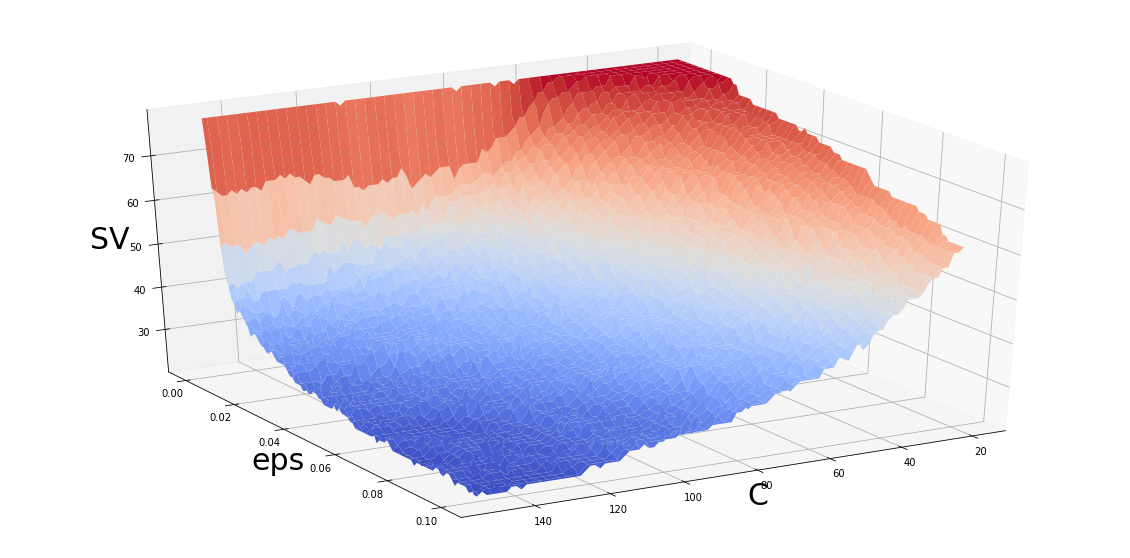

In [47]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

C_coord = np.linspace(20, 150, 100)
eps_coord = np.linspace(1e-5, 0.1, 100)
C_coord, eps_coord = np.meshgrid(C_coord, eps_coord)
Z_coord = []

for c, eps in zip(C_coord.flatten(), eps_coord.flatten()):
    svr = svm.SVR(kernel='rbf', gamma=2.0, C=c, epsilon=eps).fit(X_train, y_train)
#     MSE = mean_squared_error(y_test, svr.predict(X_test))
    Z_coord.append(svr.support_.size)

Z_coord = np.array(Z_coord).reshape(C_coord.shape)
ax.plot_surface(C_coord, eps_coord, Z_coord, cmap=cm.coolwarm)
ax.view_init(30, 60)
ax.set_xlabel('C', fontsize=30)
ax.set_ylabel('eps', fontsize=30)
ax.set_zlabel('SV', fontsize=30);

В документации к `sklearn.svm.SVR` сказано, что параметр `C` в этой функции обратно пропорционален параметру $C$ в уравнении для регуляризации.
Таким образом с ростом $\varepsilon$ и убыванием $C$ сложность модели уменьшается.
Но это должно влиять на точность модели, она будет уменьшаться.